In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

### find images

In [15]:
!ls data/images

123946.png 124105.png 124205.png 124245.png


In [16]:
# old_img_names = os.listdir(os.path.join("data", "images"))
cwd = os.getcwd()
# old_img_paths = {img_name: os.path.join(cwd, "data", "images", img_name) for img_name in old_img_names}

# for img in old_img_paths:
#     if "Screenshot" in img:
#         new_name = img[-10:]
#         new_path = os.path.join(cwd, "data", "images", new_name)
#         old_path = old_img_paths[img]
#         os.rename(old_path, new_path)

img_names = os.listdir(os.path.join("data", "images"))
cwd = os.getcwd()
img_paths = {img_name: os.path.join(cwd, "data", "images", img_name) for img_name in img_names}
img_paths.keys()

dict_keys(['123946.png', '.DS_Store', '124245.png', '124105.png', '124205.png'])

In [17]:
!ls /Users/jordansmith/Library/CloudStorage/OneDrive-Reply/CarbonIntensityProject/Carbon-Intensity-Project-/data/images

123946.png 124105.png 124205.png 124245.png


### import images

None
(1990, 663)
RGB


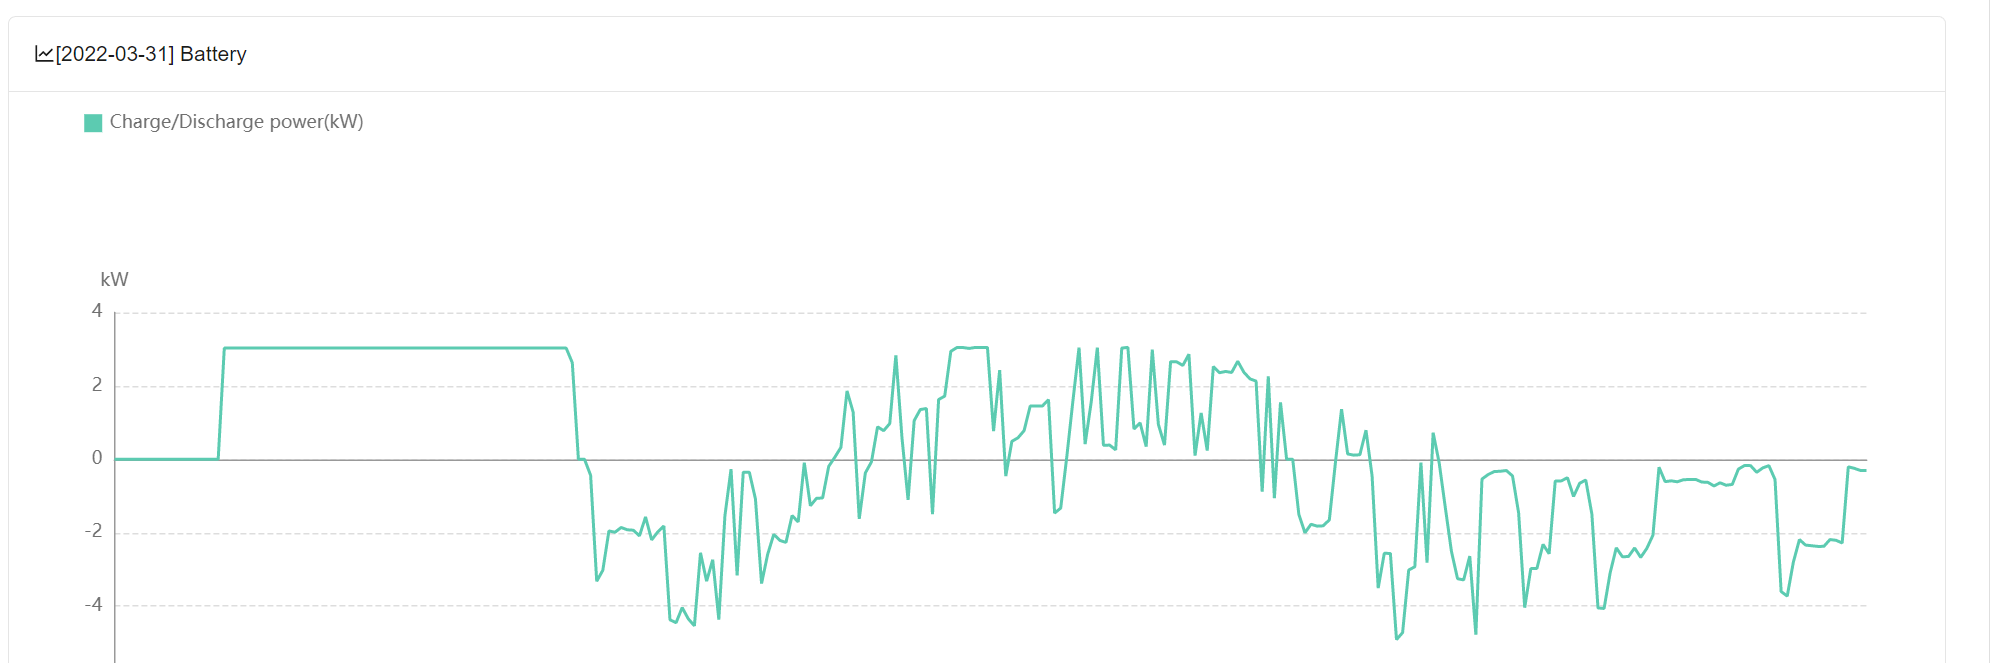

In [20]:
from PIL import Image
image = Image.open(img_paths[img_names[0]]).convert("RGB")
print(image.format)
print(image.size)
print(image.mode)
arr = np.asarray(image)
image2 = Image.fromarray(arr)

a_ = np.argwhere(arr != 255)
list_pixel_values_subsection = []

for i in range(len(a_)):
    vals_ = arr[a_[i][0], a_[i][1]]
    list_pixel_values_subsection.append(vals_)

col_names = ['r', 'g', 'b']
df = pd.DataFrame(list_pixel_values_subsection, columns=col_names)


# show the image
image

In [21]:
df

,r,g,b
0,223,223,223
1,223,223,223
2,223,223,223
3,223,223,223
4,223,223,223
...,...,...,...
158122,229,229,229
158123,229,229,229
158124,223,223,223
158125,223,223,223


### plot colours and find rgb values of plot

(None, {'r': 92, 'g': 203, 'b': 177})

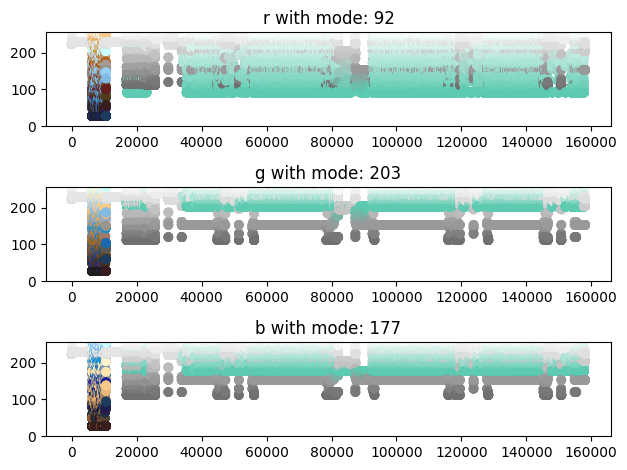

In [23]:
fig, axs = plt.subplots(3)
target_col_dict = {}
for i,col in enumerate(col_names):
    y = df[col]
    axs[i].scatter(np.arange(len(y)), y, label=col, c=np.array(df[col_names])/255)
    axs[i].set_title(f"{col} with mode: {y.mode().values[0]}")
    axs[i].set_ylim(0,255)
    target_col_dict[col] = y.mode().values[0]
    
fig.tight_layout(), target_col_dict